In [1]:
# Key Components
# State Management: Using TypedDict to define and manage the state of each customer interaction.
# Query Categorization: Classifying customer queries into Technical, Billing, or General categories.
# Sentiment Analysis: Determining the emotional tone of customer queries.
# Response Generation: Creating appropriate responses based on the query category and sentiment.
# Escalation Mechanism: Automatically escalating queries with negative sentiment to human agents.
# Workflow Graph: Utilizing LangGraph to create a flexible and extensible workflow.

# Method Details
# Initialization: Set up the environment and import necessary libraries.
# State Definition: Create a structure to hold query information, category, sentiment, and response.
# Node Functions: Implement separate functions for categorization, sentiment analysis, and response generation.
# Graph Construction: Use StateGraph to define the workflow, adding nodes and edges to represent the support process.
# Conditional Routing: Implement logic to route queries based on their category and sentiment.
# Workflow Compilation: Compile the graph into an executable application.
# Execution: Process customer queries through the workflow and retrieve results.

In [3]:
pip install langchain langgraph langchain_groq langchain_core langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.6
    Uninstalling langchain-text-splitters-0.3.6:
      Successfully uninstalled langchain-text-splitters-0.3.6
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.20
    Uninstalling langchain-0.3.20:
      Successfully uninstalled langchain-0.3.20


In [6]:
from getpass import getpass
groq_api_key = getpass("Enter your Groq API Key: ")

Enter your Groq API Key: ··········


In [14]:
from typing import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display

In [5]:
# Define State Structure

class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

In [9]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    groq_api_key = groq_api_key,
    temperature=0,
    model_name = "llama-3.3-70b-versatile"
)

In [79]:
def categorize(state: State) -> State:
  "Technical, Billing, General"
  prompt = ChatPromptTemplate.from_template(
      "Categorize the following customer query into one of these categories: "
      "Technical, Billing, General. Query: {query}"
  )
  chain = prompt | llm
  category = chain.invoke({"query": state["query"]}).content
  return {"category": category}

def analyze_sentiment(state: State) -> State:
  prompt = ChatPromptTemplate.from_template(
      "Analyze the sentiment of the following customer query"
      "Response with either 'Positive', 'Neutral' , or 'Negative'. Query: {query}"
  )
  chain = prompt | llm
  sentiment = chain.invoke({"query": state["query"]}).content
  return {"sentiment": sentiment}

def handle_technical(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "You are a technical support agent. Provide a helpful response to this query:\n\n"
        "{query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content.strip()

    return {"response": response or "I'm sorry, I couldn't process your request."}


def handle_billing(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Provide a billing support response to the following query : {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

def handle_general(state: State)->State:
  prompt = ChatPromptTemplate.from_template(
      "Provide a general support response to the following query : {query}"
  )
  chain = prompt | llm
  response = chain.invoke({"query": state["query"]}).content
  return {"response": response}

def escalate(state: State)->State:
  return {"response": "This query has been escalate to a human agent due to its negative sentiment"}

def route_query(state: State)->State:
  if state["sentiment"] == "Negative":
    return "escalate"
  elif state["category"] == "Technical":
    return "handle_technical"
  elif state["category"] == "Billing":
    return "handle_billing"
  else:
    return "handle_general"

In [80]:
workflow = StateGraph(State)

workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,{
        "handle_technical" : "handle_technical",
        "handle_billing" :  "handle_billing",
        "handle_general" : "handle_general",
        "escalate": "escalate"
    }
)

workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

workflow.set_entry_point("categorize")

app  = workflow.compile()

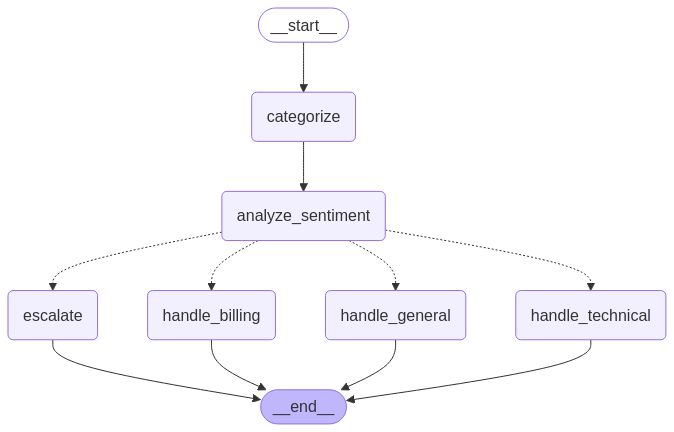

In [81]:
display(Image(
    app.get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.API
    )
))

In [82]:
def run_customer_support(query: str) -> Dict[str, str]:
  results = app.invoke({"query": query})
  return {
      "category": results["category"],
      "sentiment": results["sentiment"],
      "response": results["response"]
  }

In [90]:
query = "My internet connection is slow can you please help me out"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: My internet connection is slow can you please help me out
Category: I would categorize the customer query as: Technical.

The query is related to a specific issue with the customer's internet connection, which is a technical problem that requires assistance from a technical support team.
Sentiment: The sentiment of the customer query is: Neutral.

The customer is reporting an issue with their internet connection, but they are not expressing any strong emotions such as frustration, anger, or dissatisfaction, which would indicate a negative sentiment. Instead, they are simply stating the problem and asking for help, which is a neutral and matter-of-fact tone.
Response: I'm so sorry to hear that you're experiencing a slow internet connection. I'd be happy to help you troubleshoot the issue.

To get started, can you please tell me a bit more about your internet setup and the issues you're experiencing? For example:

* What type of internet connection do you have (e.g. Wi-Fi, Etherne

In [91]:
query = "Service is very bad"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: Service is very bad
Category: I would categorize the query "Service is very bad" as General. The customer is expressing dissatisfaction with the service, but is not providing any specific technical details or billing-related information. This type of query typically requires a general response or follow-up to gather more information about the issue.
Sentiment: Negative
Response: This query has been escalate to a human agent due to its negative sentiment




In [92]:
query = "where can i find my receipt"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: where can i find my receipt
Category: The customer query "where can I find my receipt" would be categorized as: Billing.
Sentiment: Neutral. The customer is simply asking for information about their receipt, without expressing any emotion or opinion, so the sentiment is neutral.
Response: I'd be happy to help you locate your receipt. There are a few possible places you can check, depending on how you made your purchase. Here are some suggestions:

1. **Email**: If you made an online purchase, check your email inbox for a confirmation email that may include your receipt. You can also check your spam or junk folder in case it was filtered out.
2. **Order history**: If you have an account with the retailer, you can log in to your account and check your order history. Many retailers provide a copy of your receipt in your account dashboard.
3. **Store or restaurant**: If you made a purchase in-store or at a restaurant, you can contact the store directly and ask if they have a copy of

In [93]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.4 MB/s eta 0:00:00


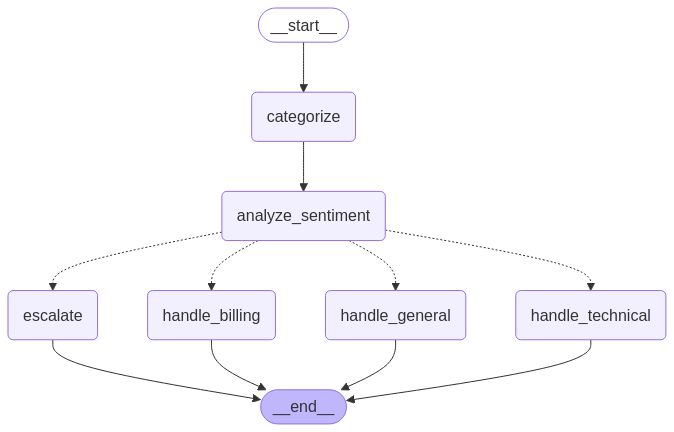

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


theme_schema%400.0.1.json:   0%|          | 0.00/12.6k [00:00<?, ?B/s]

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3355457e544954eb3d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [94]:
from typing import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str

from langchain_groq import ChatGroq

llm = ChatGroq(
    temperature=0,
    groq_api_key=groq_api_key,
    model_name="llama-3.3-70b-versatile"
)


def categorize(state: State) -> State:
    """Categorize the query."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query}"
    )
    chain = prompt | llm
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}

def analyze_sentiment(state: State) -> State:
    """Analyze sentiment of the query."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query "
        "Response with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | llm
    sentiment = chain.invoke({"query": state["query"]}).content
    return {"sentiment": sentiment}

def handle_technical(state: State) -> State:
    """Handle technical queries."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_billing(state: State) -> State:
    """Handle billing queries."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_general(state: State) -> State:
    """Handle general queries."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def escalate(state: State) -> State:
    """Escalate negative sentiment queries."""
    return {"response": "This query has been escalated to a human agent due to its negative sentiment."}

def route_query(state: State) -> State:
    """Route query based on category and sentiment."""
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Billing":
        return "handle_billing"
    else:
        return "handle_general"

workflow = StateGraph(State)

workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query, {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)

workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

workflow.set_entry_point("categorize")

app = workflow.compile()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

import gradio as gr

# Define the function that integrates the workflow.
def run_customer_support(query: str) -> Dict[str, str]:
    results = app.invoke({"query": query})
    return {
        "Category": results['category'],
        "Sentiment": results['sentiment'],
        "Response": results['response']
    }

# Create the Gradio interface
def gradio_interface(query: str):
    result = run_customer_support(query)
    return (
        f"**Category:** {result['Category']}\n\n"
        f"**Sentiment:** {result['Sentiment']}\n\n"
        f"**Response:** {result['Response']}"
    )

# Build the Gradio app
gui = gr.Interface(
    fn=gradio_interface,
    theme='Yntec/HaleyCH_Theme_Orange_Green',
    inputs=gr.Textbox(lines=2, placeholder="Enter your query here..."),
    outputs=gr.Markdown(),
    title="Customer Support Assistant",
    description="Provide a query and receive a categorized response. The system analyzes sentiment and routes to the appropriate support channel.",
)

# Launch the app
if __name__ == "__main__":
    gui.launch()